# Mixture Density Networks

Mixture density networks (MDN) (Bishop, 1994) are a class
of models obtained by combining a conventional neural network with a
mixture density model.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/mixture-density-network.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from edward.models import Categorical, Mixture, Normal
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  x = np.linspace(-10.5, 10.5, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i))
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)


def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
  """Draws samples from mixture model.

  Returns 2 d array with input X and sample from prediction of mixture model.
  """
  samples = np.zeros((amount, 2))
  n_mix = len(pred_weights[0])
  to_choose_from = np.arange(n_mix)
  for j, (weights, means, std_devs) in enumerate(
          zip(pred_weights, pred_means, pred_std)):
    index = np.random.choice(to_choose_from, p=weights)
    samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
    samples[j, 0] = x[j]
    if j == amount - 1:
      break
  return samples

## Data

We use the same toy data from
[David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), where he explains MDNs. It is an inverse problem where
for every input $x_n$ there are multiple outputs $y_n$.

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


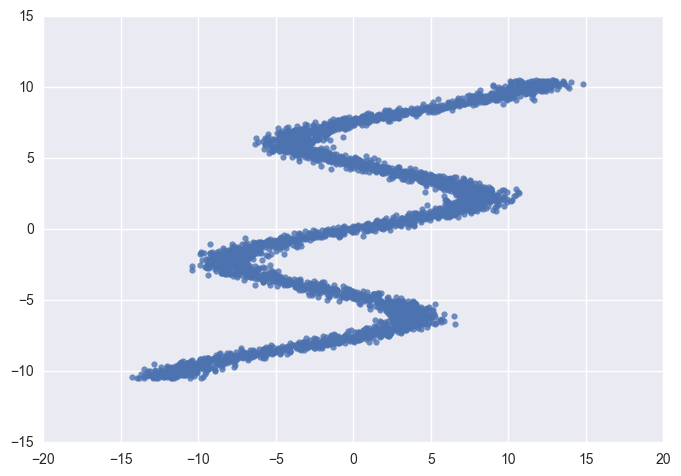

In [3]:
def build_toy_dataset(N):
  y_data = np.random.uniform(-10.5, 10.5, N)
  r_data = np.random.normal(size=N)  # random noise
  x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
  x_data = x_data.reshape((N, 1))
  return train_test_split(x_data, y_data, random_state=42)


ed.set_seed(42)

N = 5000  # number of data points
D = 1  # number of features
K = 20  # number of mixture components

X_train, X_test, y_train, y_test = build_toy_dataset(N)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))
sns.regplot(X_train, y_train, fit_reg=False)
plt.show()

We define TensorFlow placeholders, which will be used to manually feed batches of data during inference. This is [one of many ways](http://edwardlib.org/api/data) to train models with data in Edward.

In [4]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

## Model

We use a mixture of 20 normal distributions parameterized by a
feedforward network. That is, the membership probabilities and
per-component mean and standard deviation are given by the output of a
feedforward network.

We use `tf.layers` to construct neural networks. We specify
a three-layer network with 15 hidden units for each hidden layer.

In [5]:
def neural_network(X):
  """loc, scale, logits = NN(x; theta)"""
  # 2 hidden layers with 15 hidden units
  net = tf.layers.dense(X, 15, activation=tf.nn.relu)
  net = tf.layers.dense(net, 15, activation=tf.nn.relu)
  locs = tf.layers.dense(net, K, activation=None)
  scales = tf.layers.dense(net, K, activation=tf.exp)
  logits = tf.layers.dense(net, K, activation=None)
  return locs, scales, logits


locs, scales, logits = neural_network(X_ph)
cat = Categorical(logits=logits)
components = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]
y = Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))
# Note: A bug exists in Mixture which prevents samples from it to have
# a shape of [None]. For now fix it using the value argument, as
# sampling is not necessary for MAP estimation anyways.

Note that we use the `Mixture` random variable. It collapses
out the membership assignments for each data point and makes the model
differentiable with respect to all its parameters. It takes a
`Categorical` random variable as input—denoting the probability for each
cluster assignment—as well as `components`, which is a list of
individual distributions to mix over.

For more background on MDNs, take a look at
[Christopher Bonnett's blog post](http://cbonnett.github.io/MDN.html) or at Bishop (1994).

## Inference

We use MAP estimation, passing in the model and data set.
See this extended tutorial about
[MAP estimation in Edward](http://edwardlib.org/tutorials/map)

In [6]:
# There are no latent variables to infer. Thus inference is concerned
# with only training model parameters, which are baked into how we
# specify the neural networks.
inference = ed.MAP(data={y: y_ph})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

Here, we will manually control the inference and how data is passed
into it at each step.
Initialize the algorithm and the TensorFlow variables.

In [7]:
sess = ed.get_session()
tf.global_variables_initializer().run()

Now we train the MDN by calling `inference.update()`, passing
in the data. The quantity `inference.loss` is the
loss function (negative log-likelihood) at that step of inference. We
also report the loss function on test data by calling
`inference.loss` and where we feed test data to the TensorFlow
placeholders instead of training data.
We keep track of the losses under `train_loss` and `test_loss`.

In [8]:
n_epoch = 1000
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss,
                          feed_dict={X_ph: X_test, y_ph: y_test})
  inference.print_progress(info_dict)

1000/1000 [100%] ██████████████████████████████ Elapsed: 21s | Loss: 4948.319


Note a common failure mode when training MDNs is that an individual
mixture distribution collapses to a point. This forces the standard
deviation of the normal to be close to 0 and produces NaN values.
We can prevent this by thresholding the standard deviation if desired.

After training for a number of iterations, we get out the predictions
we are interested in from the model: the predicted mixture weights,
cluster means, and cluster standard deviations.

To do this, we fetch their values from session, feeding test data
`X_test` to the placeholder `X_ph`.

In [9]:
pred_weights, pred_means, pred_std = sess.run(
    [tf.nn.softmax(logits), locs, scales], feed_dict={X_ph: X_test})

Let's plot the log-likelihood of the training and test data as
functions of the training epoch. The quantity `inference.loss`
is the total log-likelihood, not the loss per data point. Below we
plot the per-data point log-likelihood by dividing by the size of the
train and test data respectively.

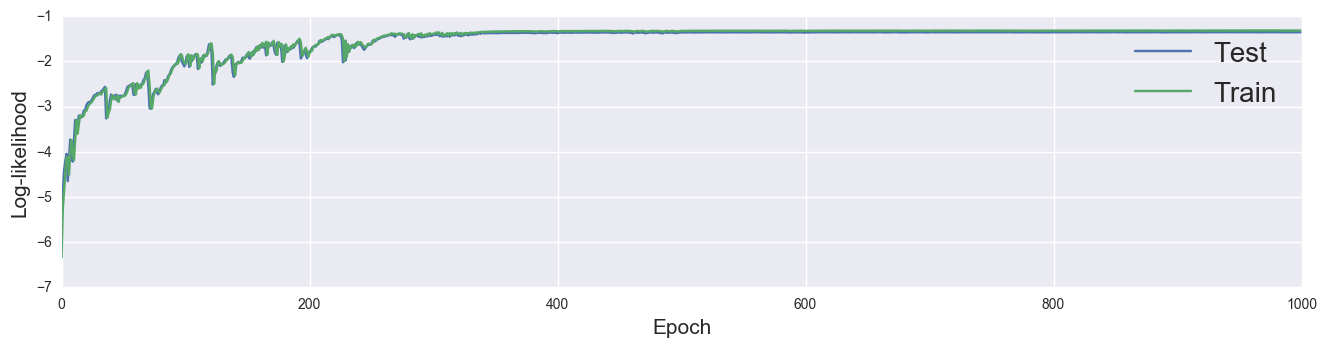

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

We see that it converges after roughly 400 iterations.

## Criticism

Let's look at how individual examples perform. Note that as this is an
inverse problem we can't get the answer correct, but we can hope that
the truth lies in area where the model has high probability.

In this plot the truth is the vertical grey line while the blue line
is the prediction of the mixture density network. As you can see, we
didn't do too bad.

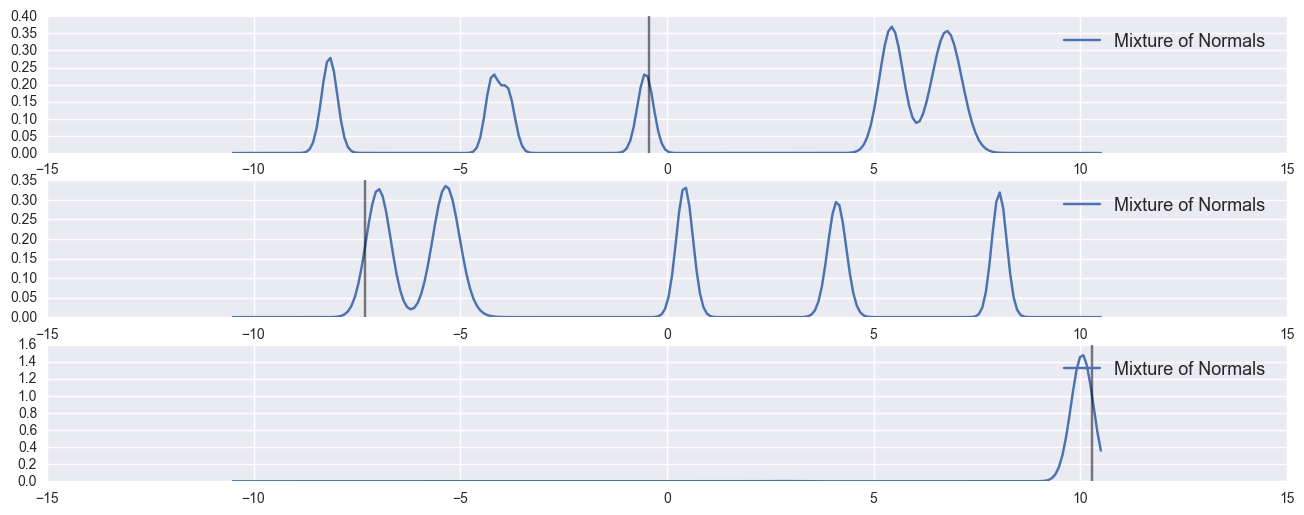

In [11]:
obj = [0, 4, 6]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6))

plot_normal_mix(pred_weights[obj][0], pred_means[obj][0],
                pred_std[obj][0], axes[0], comp=False)
axes[0].axvline(x=y_test[obj][0], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][2], pred_means[obj][2],
                pred_std[obj][2], axes[1], comp=False)
axes[1].axvline(x=y_test[obj][2], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][1], pred_means[obj][1],
                pred_std[obj][1], axes[2], comp=False)
axes[2].axvline(x=y_test[obj][1], color='black', alpha=0.5)
plt.show()

We can check the ensemble by drawing samples of the prediction and
plotting the density of those. The MDN has learned what we'd like it
to learn.

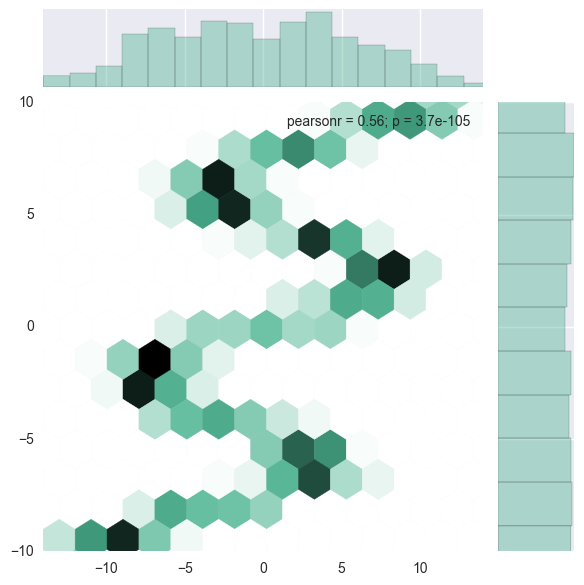

In [12]:
a = sample_from_mixture(X_test, pred_weights, pred_means,
                        pred_std, amount=len(X_test))
sns.jointplot(a[:, 0], a[:, 1], kind="hex", color="#4CB391",
              ylim=(-10, 10), xlim=(-14, 14))
plt.show()

## Acknowledgments

We thank Christopher Bonnett for writing the initial version
of this tutorial. More generally, we thank Chris for pushing forward
momentum to have Edward tutorials be accessible and easy-to-learn.